In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython

In [2]:
df = pd.read_csv("jena_climate.csv")

In [3]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

print("df shape:", df.shape)
print("train_df shape:", train_df.shape)
print("val_df shape:", val_df.shape)
print("test_df shape:", test_df.shape)

df shape: (70091, 19)
train_df shape: (49063, 19)
val_df shape: (14018, 19)
test_df shape: (7010, 19)


In [4]:
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [5]:
class WindowGenerator():
    def __init__(self, input_width:int, label_width:int, shift:int,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if self.label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                  enumerate(label_columns)}
        self.column_indices = {name:i for i, name in 
                               enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = self.input_width + self.shift
        
        self.input_slice = slice(0, self.input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
   

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, column_indices[name]] for name in self.label_columns],
                     axis=-1)

        # Slicing doesn;t preserve static shape information, so set the shapes
        # mannually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
    
        return inputs, labels
    
    def plot(self, model=None, plot_col="T (degC)", max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label="Inputs", marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                       edgecolors='k', label="Labels", c="#2ca02c", s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                       marker='X', edgecolors='k', label='Predictions',
                       c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32)
        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of 'inputs, labels' for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the '.train' dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])

In [6]:
column_indices = {name:i for i, name in enumerate(df.columns)}

In [7]:
single_step_window = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1,
    label_columns=["T (degC)"])

In [8]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [9]:
baseline = Baseline(label_index=column_indices["T (degC)"])
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(single_step_window.val)
performance["Baseline"] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 1ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


- wide_window : 24 hours of consecutive inputs and labels
- the model still makes predictions on hour into the future, based on a single input time step.

In [10]:
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1,
               label_columns=["T (degC)"])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

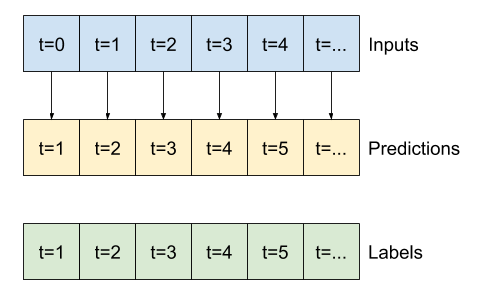

- input과 label의 timestep 개수가 같고, 
- baseline은 just forwards the input to the ouput하므로
- without any code changes로 baseline model에 pass directly할 수 있다. 

In [11]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape (32, 24, 1)


- blue inputs line : shows 각 time step에서의 temperature 값
- green labels dots: prediction time에서의 target prediction value를 나타낸다.
> input time이 아닌 prediction time에 dot들을 나타냈기 때문에, range of labels가 inputs에 비해 상대적으로 shifted 1 step된 것이다.
- orange predictions corsses: 각 ouput time step에서 model's prediction을 나타낸다. 

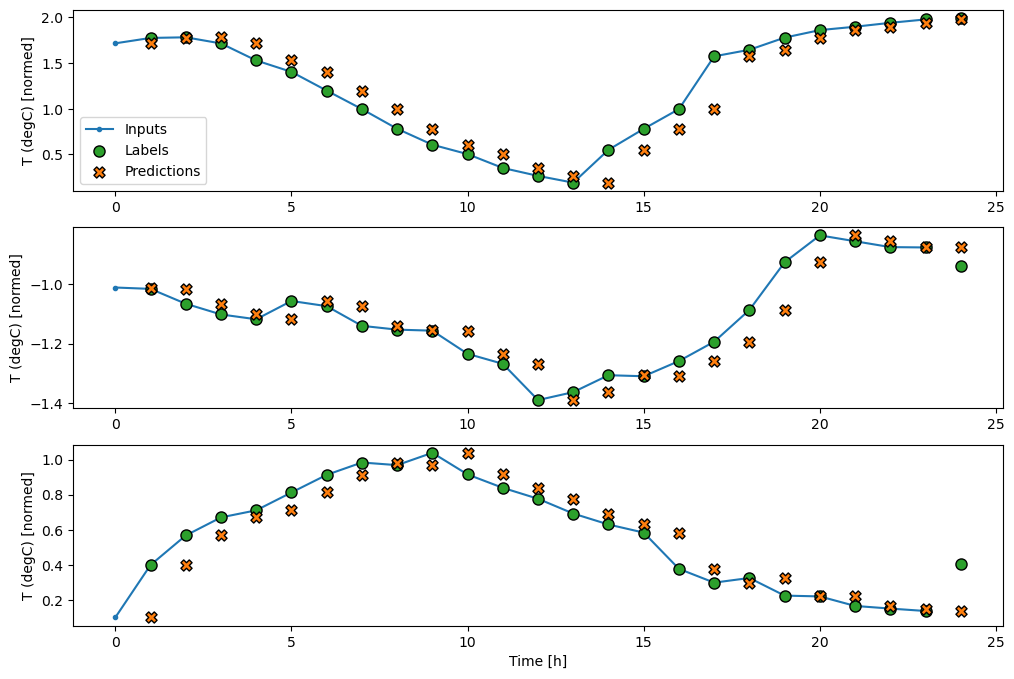

In [12]:
# baseline model의 predictions를 plot하기
# notice that it is simply the labels shifted right by one hour
wide_window.plot(baseline)

## Linear model
- tf.keras.layers.Dense layer with no activation set is a linear model.
- Dense layer는 data의 last axis만 transform시킨다:
> (batch, time, inputs) to (batch, time, units)

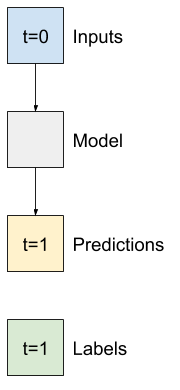

In [13]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [14]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [15]:
MY_EPOCHS = 20
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                     patience=patience,
                                                     mode="min")
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MY_EPOCHS,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [16]:
history = compile_and_fit(linear, single_step_window)

val_performance["Linear"] = linear.evaluate(single_step_window.val)
performance["Linear"] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.1386 - mean_absolute_error: 0.2131 - val_loss: 0.0150 - val_mean_absolute_error: 0.0909
Epoch 2/20
1534/1534 [==============================] - 2s 987us/step - loss: 0.0110 - mean_absolute_error: 0.0774 - val_loss: 0.0091 - val_mean_absolute_error: 0.0705
Epoch 3/20
1534/1534 [==============================] - 1s 940us/step - loss: 0.0092 - mean_absolute_error: 0.0705 - val_loss: 0.0089 - val_mean_absolute_error: 0.0700
Epoch 4/20
1534/1534 [==============================] - 1s 934us/step - loss: 0.0091 - mean_absolute_error: 0.0700 - val_loss: 0.0087 - val_mean_absolute_error: 0.0690
Epoch 5/20
1534/1534 [==============================] - 2s 974us/step - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0087 - val_mean_absolute_error: 0.0693
Epoch 6/20
439/439 [==============================] - 0s 732us/step - loss: 0.0088 - mean_absolute_error: 0.0698


- baseline model과 마찬가지로 linear model도 can be called on batches of wide windows.
- model makes a set of independent predictions on consecutive(연이은) time steps.

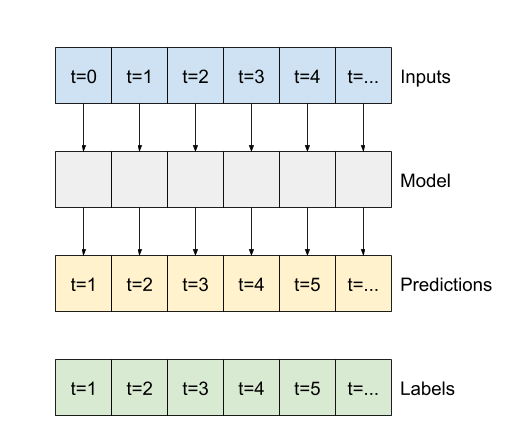

In [17]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


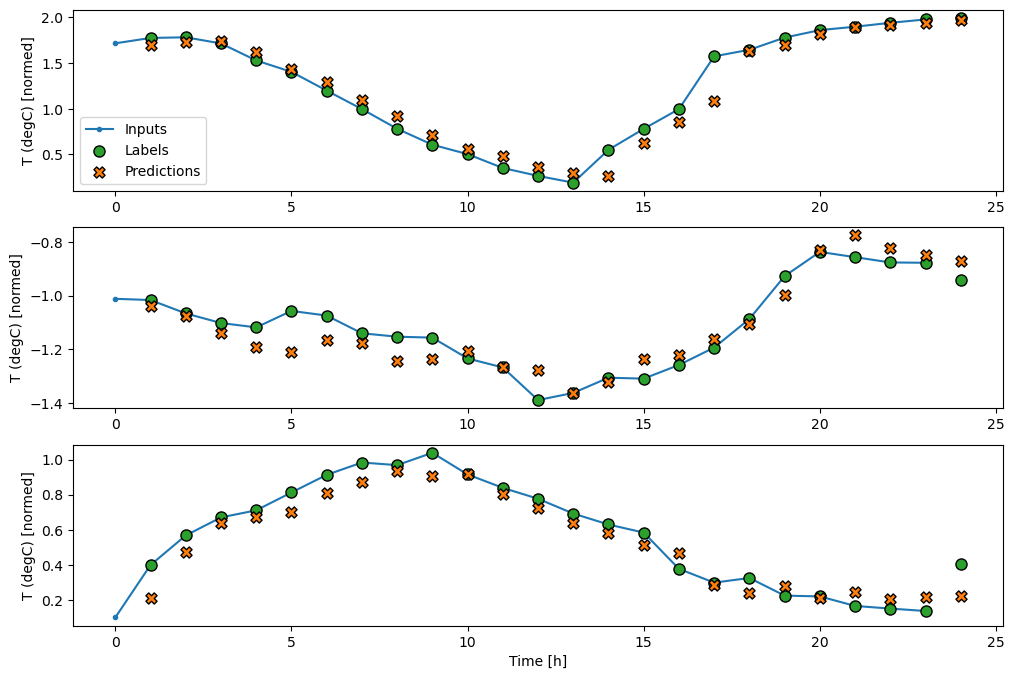

In [18]:
# plot of its example predictions  on the wide_window
# this is way better than the baseline model in most of cases.
wide_window.plot(linear)

- linear model을 interpret하기 위해 pull out the layer's weights 
- and visualize the weight assigned to each input:

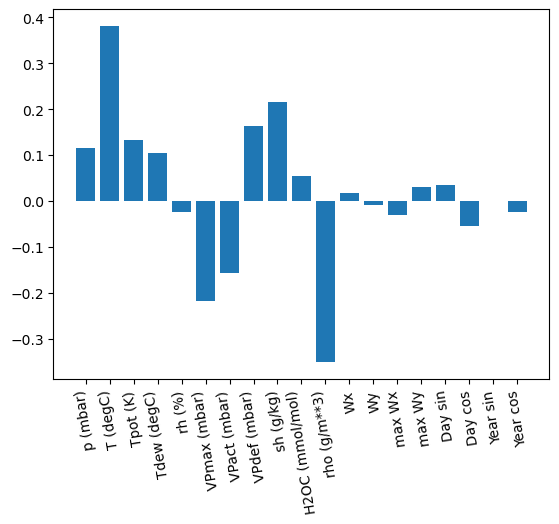

In [19]:
plt.bar(x = range(len(train_df.columns)),
       height=linear.layers[0].kernel[:, 0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=99)

- sometimes the model doesn't even place the most weight on the input 'T (degC)'

## Dense
deeper single input step models

In [20]:
#single_step_window.example

In [21]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'), # 왜 input node 64개인가?
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance["Dense"] = dense.evaluate(single_step_window.val)
performance["Dense"] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 3s 1ms/step - loss: 0.0171 - mean_absolute_error: 0.0799 - val_loss: 0.0090 - val_mean_absolute_error: 0.0719
Epoch 2/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0078 - mean_absolute_error: 0.0636 - val_loss: 0.0083 - val_mean_absolute_error: 0.0675
Epoch 3/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0612 - val_loss: 0.0069 - val_mean_absolute_error: 0.0597
Epoch 4/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0599 - val_loss: 0.0066 - val_mean_absolute_error: 0.0574
Epoch 5/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0593 - val_loss: 0.0068 - val_mean_absolute_error: 0.0590
Epoch 6/20
439/439 [==============================] - 0s 798us/step - loss: 0.0067 - mean_absolute_error: 0.0572


In [22]:
print("Input shape:",wide_window.example[0].shape)
print("Output shape:", dense(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


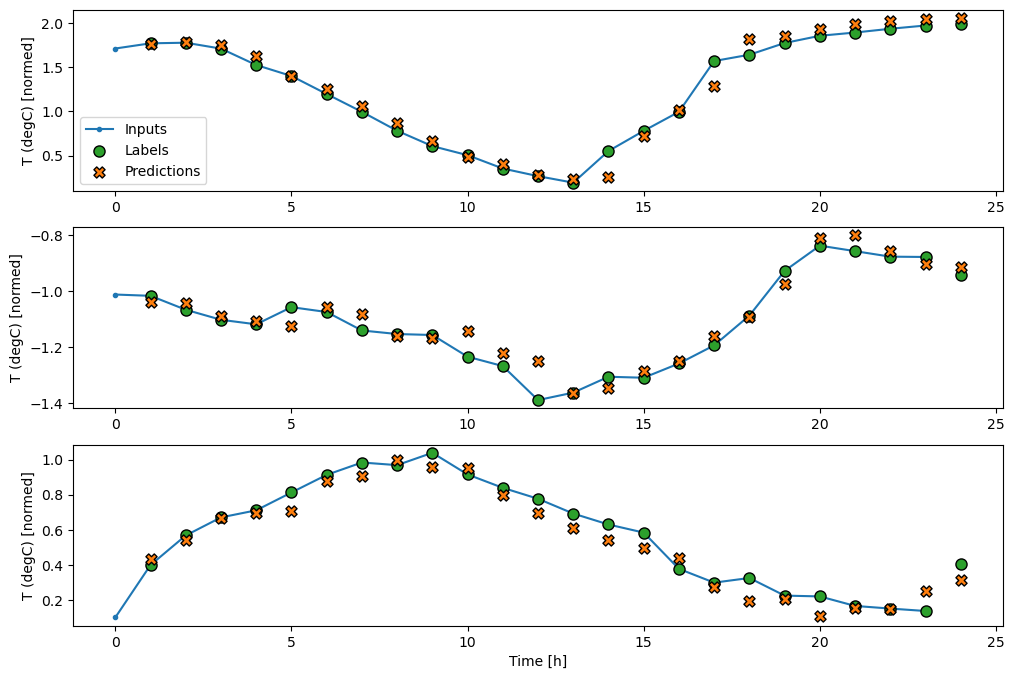

In [23]:
wide_window.plot(dense)

## multi-step dense

- single-time-step model has no context for the current values of its inputs.
- It can't see how the input features are changing over time.
- To address this issue, the model needs to access to multiple time steps when making predictions:

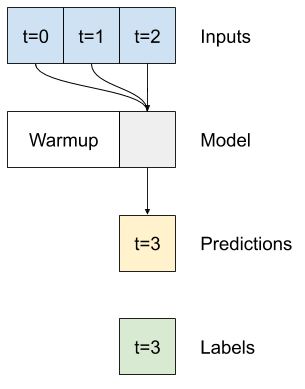

The baseline, linear and dense models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a WindowGenerator that will produce batches of three-hour inputs and one-hour labels:

In [24]:
# Note that the Window's shift parameter is relative to the end of the two-windows.
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=["T (degC)"])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

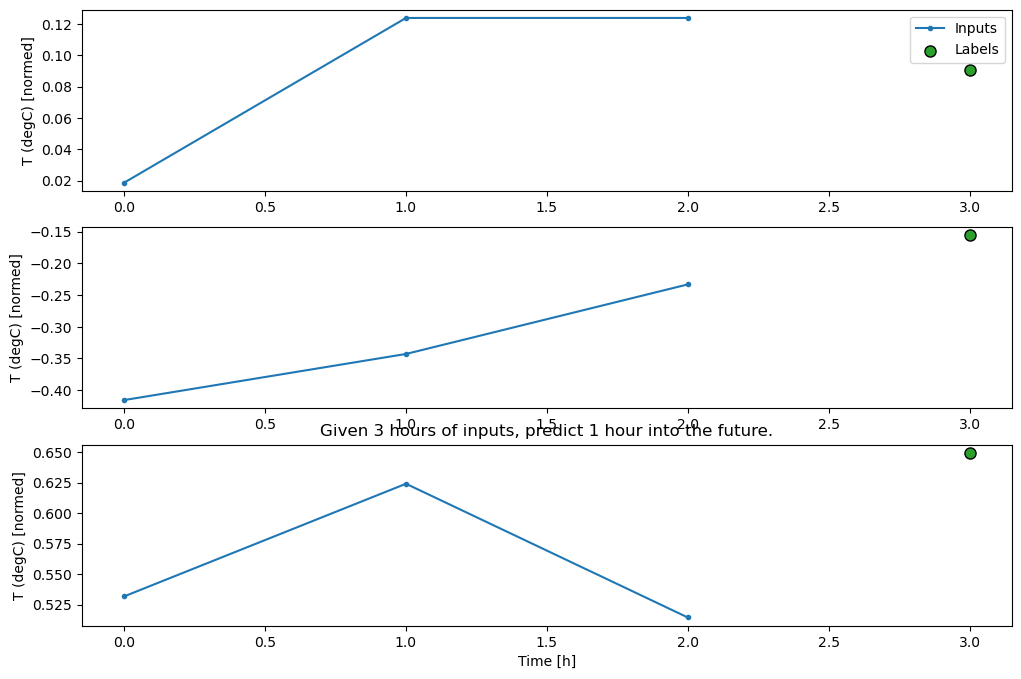

In [25]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

- dense model을 train on a multiple-input-step window 하기 위해선, 
- `tf.keras.layers.Flatten`를 add as the first layer of the model 해야 한다:
> 즉, dense 모델을 수정해야 한다.

In [26]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (output) => (1, ouputs)
    tf.keras.layers.Reshape([1, -1])
])

In [27]:
print('Input shape:', conv_window.example[0].shape)
print('Ouput shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Ouput shape: (32, 1, 1)


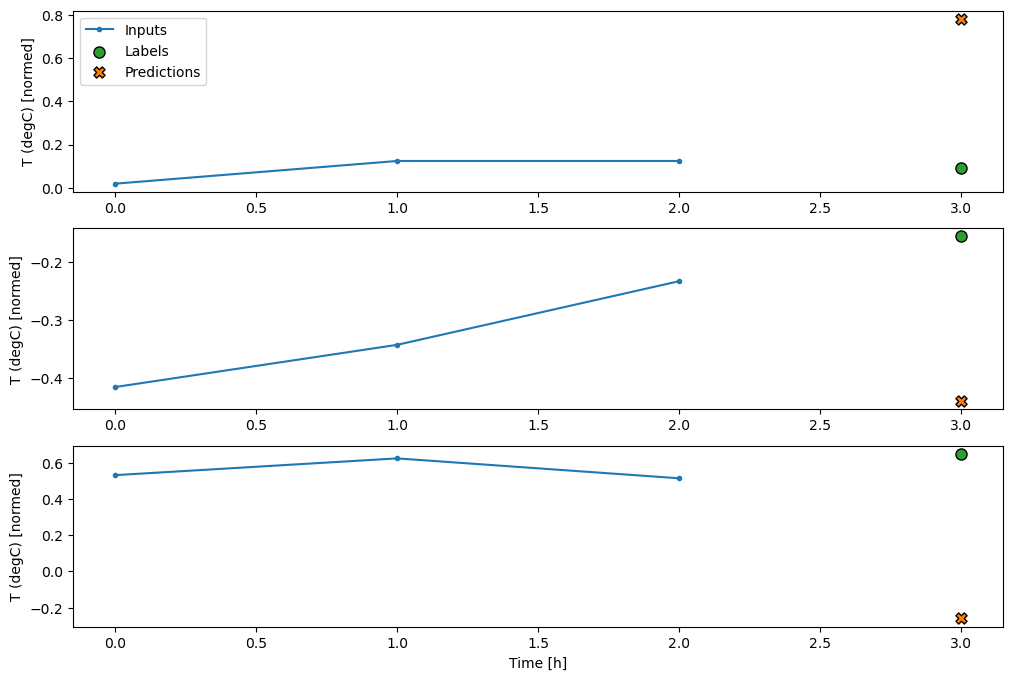

In [28]:
conv_window.plot(multi_step_dense)

The main donw-side of this approach is that the resulting model can be executed on input windows of exactly this shape.

In [29]:
print("Input shape:",wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling layer 'sequential_2' (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Call arguments received by layer 'sequential_2' (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


ValueError: Exception encountered when calling layer 'sequential_3' (type Sequential).

Input 0 of layer "dense_7" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Call arguments received by layer 'sequential_3' (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None

**The convolutional models in the next section fix this problem.**

## convolutional neural network
A  convolutional layer(`tf.keras.layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the same model a  `multi_step_dense`, re-written with a convolution.

In [30]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                          kernel_size=(CONV_WIDTH),
                          activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

Run it on an example batch to check that model produces the expected shape:

In [31]:
print("Conv model on 'conv_window'")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on 'conv_window'
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Train and evaluate it on the `conv_window` and it should give performance similar to the `multi_step_dense`model.

In [32]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance["Conv"] = conv_model.evaluate(conv_window.val)
performance["Conv"] = conv_model.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 0s 814us/step - loss: 0.0063 - mean_absolute_error: 0.0575


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

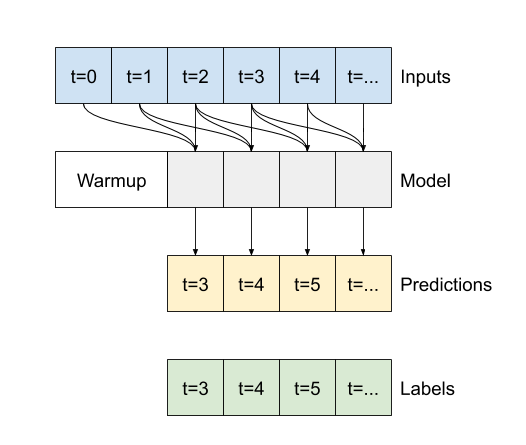

If you run it on wider input, it produces wider ouput:

In [33]:
print("Wide Window")
print("Input shape:", wide_window.example[0].shape)
print("Labels shape:", wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide Window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the ouput is shorter than the input. To make training or plotting work, you need the labels, and predictions to have the same length. So bulid a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match:

In [37]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=["T (degC)"])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [40]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now you can plot the model's predictions on a wider window. Note 3 input time steps before the first prediction. Every prediction here is based on the **3 preceding time steps**:

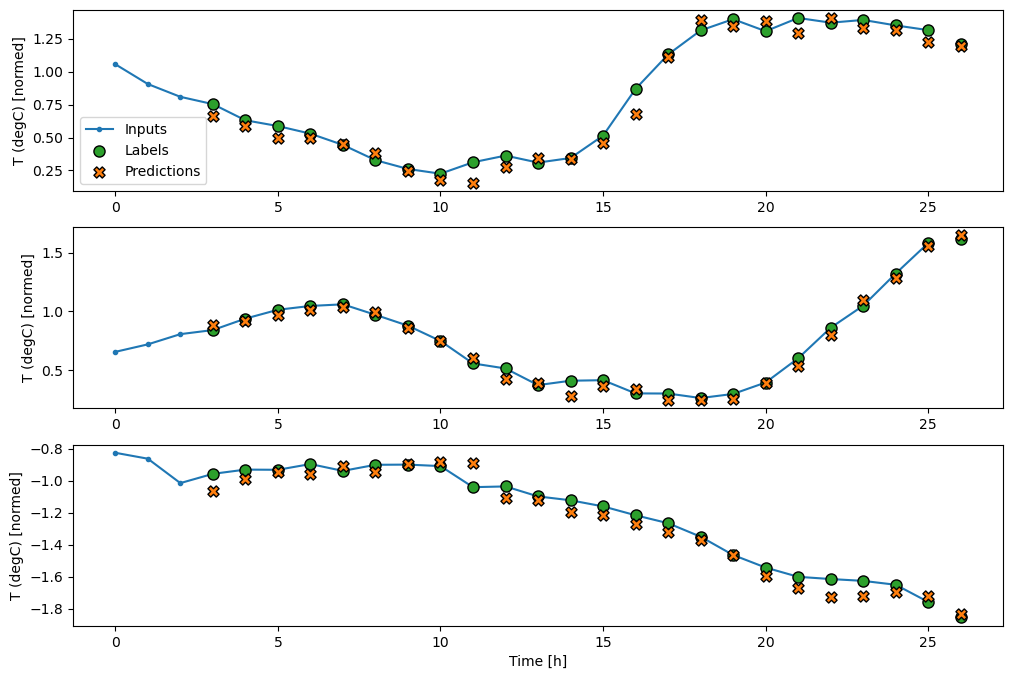

In [41]:
wide_conv_window.plot(conv_model)

## recurrent neural network

RNN layer called Long-Short-Term Memory(`tf.keras.layers.LSTM`)

In [43]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True`, the model can be trained on 24 hours of data at a time.

In [44]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [45]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance["LSTM"] = lstm_model.evaluate(wide_window.val)
performance["LSTM"] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 1s 2ms/step - loss: 0.0056 - mean_absolute_error: 0.0511


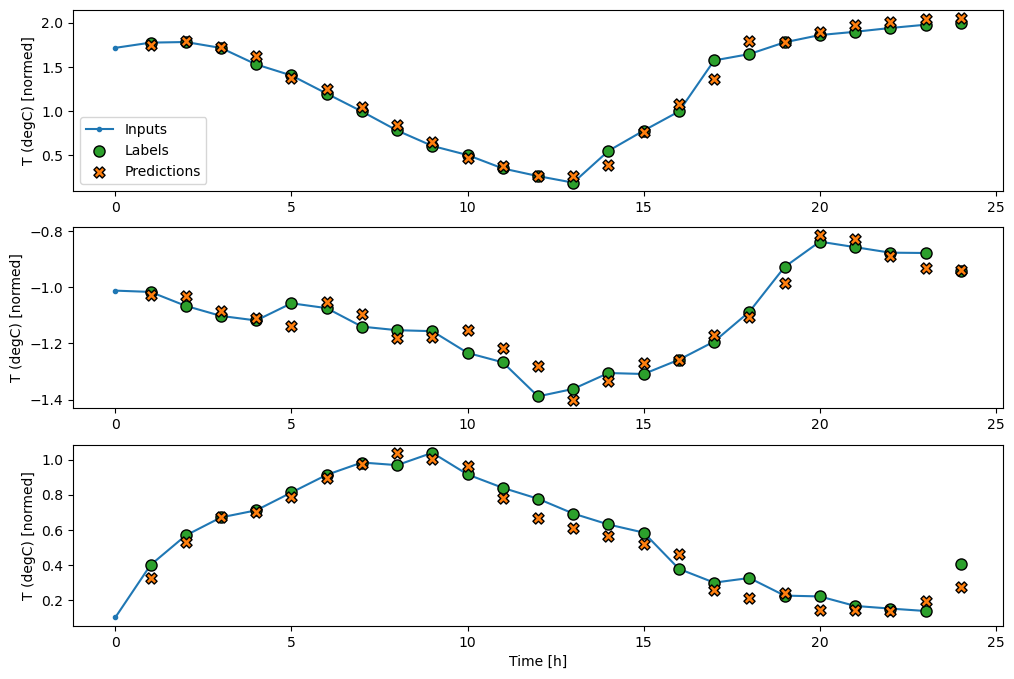

In [55]:
wide_window.plot(lstm_model)

With this dataset, typically each models does slightly better than the one before it:

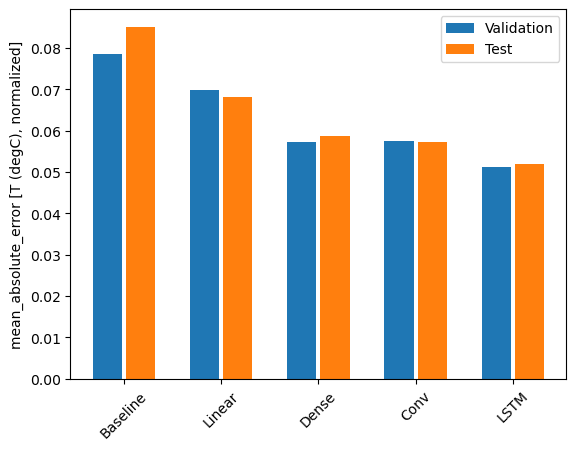

In [51]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(tcks=x, labels=performance.keys(),
          rotatio=4

In [52]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0681
Dense       : 0.0588
Conv        : 0.0574
LSTM        : 0.0519
